In [1]:
# install.packages("ggplot2")
# install.packages("gridExtra")
# install.packages("dplyr")
# install.packages("tidyr")
# install.packages("sf")
# install.packages("leaflet")
# install.packages("tidyverse")
# install.packages("showtext")
# install.packages("stringr")

library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(sf)
library(leaflet)
library(tidyverse)
library(showtext)
library(stringr)
font_add_google("Nanum Gothic", "nanumgothic")
showtext_auto()


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.8.0, GDAL 3.1.2, PROJ 6.1.0

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Loading required package: sysfonts

Loading required package: showtextdb



## 최종적으로 도출된 위험지역 100개에 대한 데이터 불러오기

In [2]:
top100 <- read.csv('top_100_visu.csv')
dim(top100)
top100 %>% head(3)

[1] 100  67

,DGI,DI_ratio,index,gid,difference,false_rank,true_rank,x,y,중상자이상수,⋯,차대사람..60대.이상,차대차..20대,차대차..20대.미만,차대차..30대,차대차..40대,차대차..50대,차대차..60대.이상,사망자수,경상자수,중상자수
,<dbl>,<int>,<int>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1.776024,4,3634,다바882173,0.0000000,1,1,127.3690,36.35349,4,⋯,0,11,1,8,4,17,6,0,7,4
2,1.648503,6,397,다바888170,-0.1275206,2,2,127.3757,36.35079,6,⋯,2,2,0,0,1,1,2,0,7,6
3,1.435875,3,1020,다바931161,-0.2126279,3,3,127.4237,36.34272,3,⋯,3,3,0,1,9,9,6,0,15,3


In [3]:
top100$사상자수 <- rowSums(top100[ ,64:66])

In [4]:
rank_df <- top100[,c(1,4,10,25,26)]
rank_df %>% head(3)

,DGI,gid,중상자이상수,사고건수,사상자수
,<dbl>,<fct>,<int>,<int>,<dbl>
1,1.776024,다바882173,4,48,13
2,1.648503,다바888170,6,63,9
3,1.435875,다바931161,3,31,21


In [5]:
grid <- read.csv("accident_grid.csv")
names(grid)[4] <- 'longitude'
names(grid)[5] <- 'latitude'

base <- st_read("25.대전광역시_법정경계(시군구).geojson")

Reading layer `28' from data source `/opt/app-root/src/Data/25.대전광역시_법정경계(시군구).geojson' using driver `GeoJSON'
Simple feature collection with 5 features and 2 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 127.2467 ymin: 36.1831 xmax: 127.5597 ymax: 36.50023
geographic CRS: WGS 84


### 빈번성, 심각성, 규모성에 해당되는 변수들을 추출하고, '저, 중, 고' 라는 값의 factor 형 변수 추가
- 빈번성: 사고건수
- 심각성: 중상자이상수
- 규모성: 사상자수

In [6]:
rank_df$심각성 <- cut(rank_df$중상자이상수, breaks = c(0,4,8,23), include.lowest = TRUE, right = FALSE, labels = c("저","중","고"))
rank_df$빈번성 <- cut(rank_df$사고건수, breaks = c(0,18,34,63), include.lowest = TRUE, right = FALSE, labels = c("저","중","고"))
rank_df$규모성 <- cut(rank_df$사상자수, breaks = c(0,11,25,51), include.lowest = TRUE, right = FALSE, labels = c("저","중","고"))
rank_df %>% head(3)

,DGI,gid,중상자이상수,사고건수,사상자수,심각성,빈번성,규모성
,<dbl>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>
1,1.776024,다바882173,4,48,13,중,고,중
2,1.648503,다바888170,6,63,9,중,고,저
3,1.435875,다바931161,3,31,21,저,중,중


In [7]:
which(colnames(top100) == "차대사람..20대")
which(colnames(top100) == "차대차..60대.이상")

[1] 53

[1] 64

In [8]:
# 연령대별 데이터도 고려하기 위하여 top100 데이터에서 연령과 관련된 변수도 추가
rank_df2 <- cbind(rank_df,top100[,53:64])
rank_df2 %>% head(3)

,DGI,gid,중상자이상수,사고건수,사상자수,심각성,빈번성,규모성,차대사람..20대,차대사람..20대.미만,차대사람..30대,차대사람..40대,차대사람..50대,차대사람..60대.이상,차대차..20대,차대차..20대.미만,차대차..30대,차대차..40대,차대차..50대,차대차..60대.이상
,<dbl>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1.776024,다바882173,4,48,13,중,고,중,0,0,0,0,0,0,11,1,8,4,17,6
2,1.648503,다바888170,6,63,9,중,고,저,37,11,4,2,1,2,2,0,0,1,1,2
3,1.435875,다바931161,3,31,21,저,중,중,0,0,0,0,0,3,3,0,1,9,9,6


In [9]:
# 교통안전시설물과의 인과 관계를 고려하기 위하여 시설물과 관련된 변수도 추가
rank_df3 <- cbind(rank_df2,top100[,names(top100)[c(27:29,42:45,47, 49)]])
names(rank_df3)

[1] "DGI"                      "gid"                     
 [3] "중상자이상수"             "사고건수"                
 [5] "사상자수"                 "심각성"                  
 [7] "빈번성"                   "규모성"                  
 [9] "차대사람..20대"           "차대사람..20대.미만"     
[11] "차대사람..30대"           "차대사람..40대"          
[13] "차대사람..50대"           "차대사람..60대.이상"     
[15] "차대차..20대"             "차대차..20대.미만"       
[17] "차대차..30대"             "차대차..40대"            
[19] "차대차..50대"             "차대차..60대.이상"       
[21] "신호등_보행자수"          "신호등_차량등수"         
[23] "cctv수"                   "이상안개시간동반사고건수"
[25] "안전지대수"               "중앙분리대수"            
[27] "정차금지지대수"           "교통안전표지수"          
[29] "횡단보도수"

In [10]:
# 사고유형을 차대차, 차대사람으로 단순화시키기 위해 사고유형 변수를 자르기
accident <- read.csv("1.대전광역시_교통사고내역(2017~2019).csv")
accident2 <- accident  %>% separate(col = 사고유형, sep = " ", into = c("사고유형2","a","사고유형3"))
accident2$a <- NULL
accident$사고유형2 <- accident2$사고유형2
accident$사고유형3 <- accident2$사고유형3
accident$사고유형3 <- ifelse(accident$사고유형 == "차대차 - 기타","기타2",
                         ifelse(accident$사고유형 == "차대사람 - 기타","기타1",
                                ifelse(accident$사고유형 == "차대단독 - 기타","기타3", accident$사고유형3)))

dim(accident)
accident %>% head(3)

Warning message:
“Expected 3 pieces. Additional pieces discarded in 69 rows [618, 651, 1355, 1391, 1492, 1667, 1889, 2035, 2054, 2377, 3088, 3205, 3244, 3360, 3448, 3878, 4303, 4405, 5203, 6775, ...].”


[1] 23652    18

,사고일,시군구,사고유형,법규위반,사고내용,사망자수,중상자수,경상자수,부상신고자수,가해운전자.차종,가해운전자.연령대,가해운전자.성별,피해운전자.차종,피해운전자.연령대,피해운전자.성별,gid,사고유형2,사고유형3
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>
1,2017-01-01,대전광역시 서구 용문동,차대차 - 측면충돌,안전운전불이행,중상사고,0,1,1,0,승용,50대,남,승용,60대,남,다바905151,차대차,측면충돌
2,2017-01-01,대전광역시 서구 탄방동,차대차 - 추돌,안전운전불이행,경상사고,0,0,1,0,승용,50대,남,승용,30대,남,다바905166,차대차,추돌
3,2017-01-01,대전광역시 서구 둔산동,차대사람 - 횡단중,안전운전불이행,중상사고,0,1,0,0,승용,30대,남,보행자,10대,여,다바888169,차대사람,횡단중


### 사고유형별 사고건수를 막대 그래프로 표현하는 함수

In [11]:
draw_bar <- function(gid,title){
    draw_data <- accident[accident$gid == gid & accident$사고유형2 != "차량단독",] %>% group_by(사고유형3,사고유형2)  %>% summarise(사고건수 = n())
    draw_data  %>% ggplot(aes(x = reorder(사고유형3,desc(사고건수)),y = 사고건수,
                               fill = 사고유형2)) + 
    geom_col() +
    labs(title = title,x = "사고유형", y = "사고건수") +
    geom_text(aes(label= 사고유형3), size=6, colour="black", vjust = -1) +
    geom_text(aes(label= 사고건수), size=10, colour="white", position=position_stack(0.5)) +
    scale_fill_manual(values = c("#B2DC31", "#0A3C8B")) +
    theme_bw() +
    theme(plot.title = element_text(size = 40),
         axis.title.x = element_text(size = 30),
         axis.title.y = element_text(size = 30),
         axis.text.x = element_blank(),
         legend.title = element_text(size = 30),
         legend.box.background = element_rect(colour="white", size=2),
         legend.text = element_text(size = 20))
}

### 연령별 및 사고유형별 사고건수를 막대 그래프로 표현하는 함수

In [12]:
draw_bar2 <- function(df,gid,title){
    draw_data <- df[df$gid == gid,]  %>% gather("연령별_사고유형","건수",차대사람..20대:차대차..60대.이상)
    draw_data2 <- draw_data[,18:19]
    draw_data2
    draw_data2  %>% ggplot(aes(연령별_사고유형, y = 건수,
                              fill = 연령별_사고유형)) +
    geom_col() +
    labs(title = title,x = "연령별_사고유형", y = "사고건수") +
    geom_text(aes(label= 건수), size=10, colour="white", position=position_stack(0.5)) +
    coord_flip() +
    theme_bw() +
    theme(plot.title = element_text(size = 40),
        legend.position = 'none',
         axis.title.x = element_text(size = 30),
         axis.title.y = element_text(size = 30),
         axis.text.y = element_text(size = 20))
}

### 격자내 시설물 수를 막대 그래프로 표현하는 함수

In [13]:
draw_bar3 <- function(gid,title){
    draw_data <- draw_data <- top100_count[top100_count$gid == gid,]  %>% gather("시설물","건수",신호등_보행자수:횡단보도수)
    draw_data2 <- draw_data[2:3]
    draw_data2  %>% ggplot(aes(시설물, y = 건수,
                              fill = 시설물)) +
    geom_col() +
    labs(title = title,x = "시설물", y = "시설물수") +
    geom_text(aes(label= 건수), size=10, colour="white", position=position_stack(0.5)) +
    coord_flip() +
    theme_bw() +
    theme(plot.title = element_text(size = 40),
        legend.position = 'none',
         axis.title.x = element_text(size = 30),
         axis.title.y = element_text(size = 30),
         axis.text.y = element_text(size = 20))
}

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)

In [15]:
# 유형별 그래프를 그리기 위하여 사고유형 변수들을 전처리
accident[accident$gid %in% rank_df3$gid,]  %>% group_by(gid,사고유형) %>% count() %>% spread(사고유형,n) -> accident2
accident2[is.na(accident2)] <- 0
dim(accident2)
accident2 %>% head(3)

[1] 100  15

gid,차대사람 - 기타,차대사람 - 길가장자리구역통행중,차대사람 - 보도통행중,차대사람 - 차도통행중,차대사람 - 횡단중,차대차 - 기타,차대차 - 정면충돌,차대차 - 추돌,차대차 - 측면충돌,차대차 - 후진중충돌,차량단독 - 공작물충돌,차량단독 - 기타,차량단독 - 전도전복,차량단독 - 전도전복 - 전도
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
다바831220,1,0,0,0,0,10,0,32,9,0,0,0,0,0
다바833216,0,0,0,0,1,7,0,6,7,0,0,0,0,0
다바836211,0,0,0,0,0,3,1,14,5,0,0,1,0,0


In [16]:
rank_df4 <- rank_df3 %>% left_join(accident2, by = "gid")
rank_df4 %>% head(3)

,DGI,gid,중상자이상수,사고건수,사상자수,심각성,빈번성,규모성,차대사람..20대,차대사람..20대.미만,⋯,차대사람 - 횡단중,차대차 - 기타,차대차 - 정면충돌,차대차 - 추돌,차대차 - 측면충돌,차대차 - 후진중충돌,차량단독 - 공작물충돌,차량단독 - 기타,차량단독 - 전도전복,차량단독 - 전도전복 - 전도
,<dbl>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1.776024,다바882173,4,48,13,중,고,중,0,0,⋯,0,14,1,7,25,0,1,0,0,0
2,1.648503,다바888170,6,63,9,중,고,저,37,11,⋯,5,2,0,0,3,1,0,0,0,0
3,1.435875,다바931161,3,31,21,저,중,중,0,0,⋯,3,3,2,6,17,0,0,0,0,0


## [심층분석] 빈번성, 심각성, 규모성 변수에서 '고'가 2개 이상인 지역들을 시각화 및 거리뷰 분석

In [17]:
rank_df4 <- rank_df4[,c(-(39:42), -24)] # 차량단독 유형은 제거
dim(rank_df4)
rank_df4 %>% head(3)

[1] 100  38

,DGI,gid,중상자이상수,사고건수,사상자수,심각성,빈번성,규모성,차대사람..20대,차대사람..20대.미만,⋯,차대사람 - 기타,차대사람 - 길가장자리구역통행중,차대사람 - 보도통행중,차대사람 - 차도통행중,차대사람 - 횡단중,차대차 - 기타,차대차 - 정면충돌,차대차 - 추돌,차대차 - 측면충돌,차량단독 - 전도전복 - 전도
,<dbl>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1.776024,다바882173,4,48,13,중,고,중,0,0,⋯,0,0,0,0,0,14,1,7,25,0
2,1.648503,다바888170,6,63,9,중,고,저,37,11,⋯,27,21,0,4,5,2,0,0,3,0
3,1.435875,다바931161,3,31,21,저,중,중,0,0,⋯,0,0,0,0,3,3,2,6,17,0


In [18]:
# 빈번성, 심각성, 규모성 변수에서 고가 2개 이상인 행만 추출
rank_last <- rank_df4[rank_df4$gid %in% c('다바840114', '다바890176', '다바905178', '다바960132', '다바831220'), ]  
rank_last

,DGI,gid,중상자이상수,사고건수,사상자수,심각성,빈번성,규모성,차대사람..20대,차대사람..20대.미만,⋯,차대사람 - 기타,차대사람 - 길가장자리구역통행중,차대사람 - 보도통행중,차대사람 - 차도통행중,차대사람 - 횡단중,차대차 - 기타,차대차 - 정면충돌,차대차 - 추돌,차대차 - 측면충돌,차량단독 - 전도전복 - 전도
,<dbl>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
8,1.240627,다바840114,13,33,29,고,중,고,0,0,⋯,0,0,0,0,1,11,0,5,16,0
10,1.225200,다바890176,9,24,30,고,중,고,1,0,⋯,1,0,0,0,2,11,0,0,10,0
13,1.192602,다바905178,11,34,26,고,고,고,0,0,⋯,0,0,0,0,2,8,3,6,14,0
15,1.144431,다바960132,23,24,33,고,중,고,0,0,⋯,1,0,0,0,0,2,2,1,17,0
88,0.721156,다바831220,8,52,26,고,고,고,0,0,⋯,1,0,0,0,0,10,0,32,9,0


In [19]:
top100_count <- top100[,names(top100)[c(4,27:29,43:47,49)]] # 교통안전시설물 관련 변수들만 추출
top100_count %>% head()

,gid,신호등_보행자수,신호등_차량등수,cctv수,안전지대수,중앙분리대수,정차금지지대수,도로속도표시수,교통안전표지수,횡단보도수
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,다바882173,4,11,0,1,0,0,5,10,3
2,다바888170,0,0,0,0,0,1,0,2,1
3,다바931161,5,10,0,2,0,0,0,18,5
4,다바882172,3,6,0,1,0,0,0,8,2
5,다바863167,4,6,1,5,0,0,0,17,7
6,다바841112,4,4,0,2,0,0,0,11,2


#### (1) 다바840114 그래프

`summarise()` regrouping output by '사고유형3' (override with `.groups` argument)



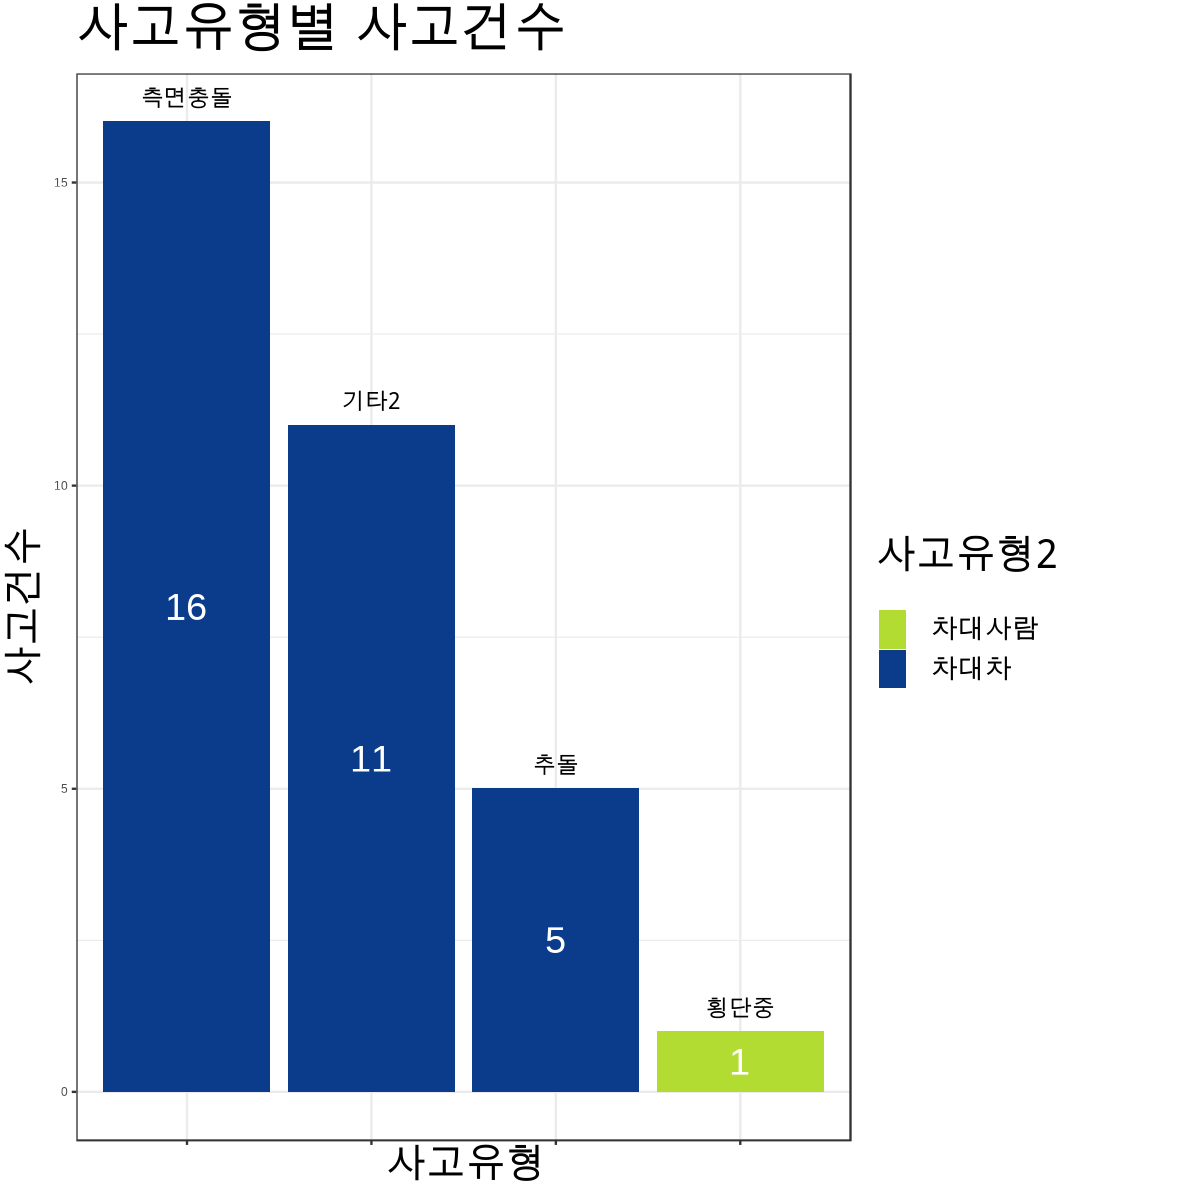

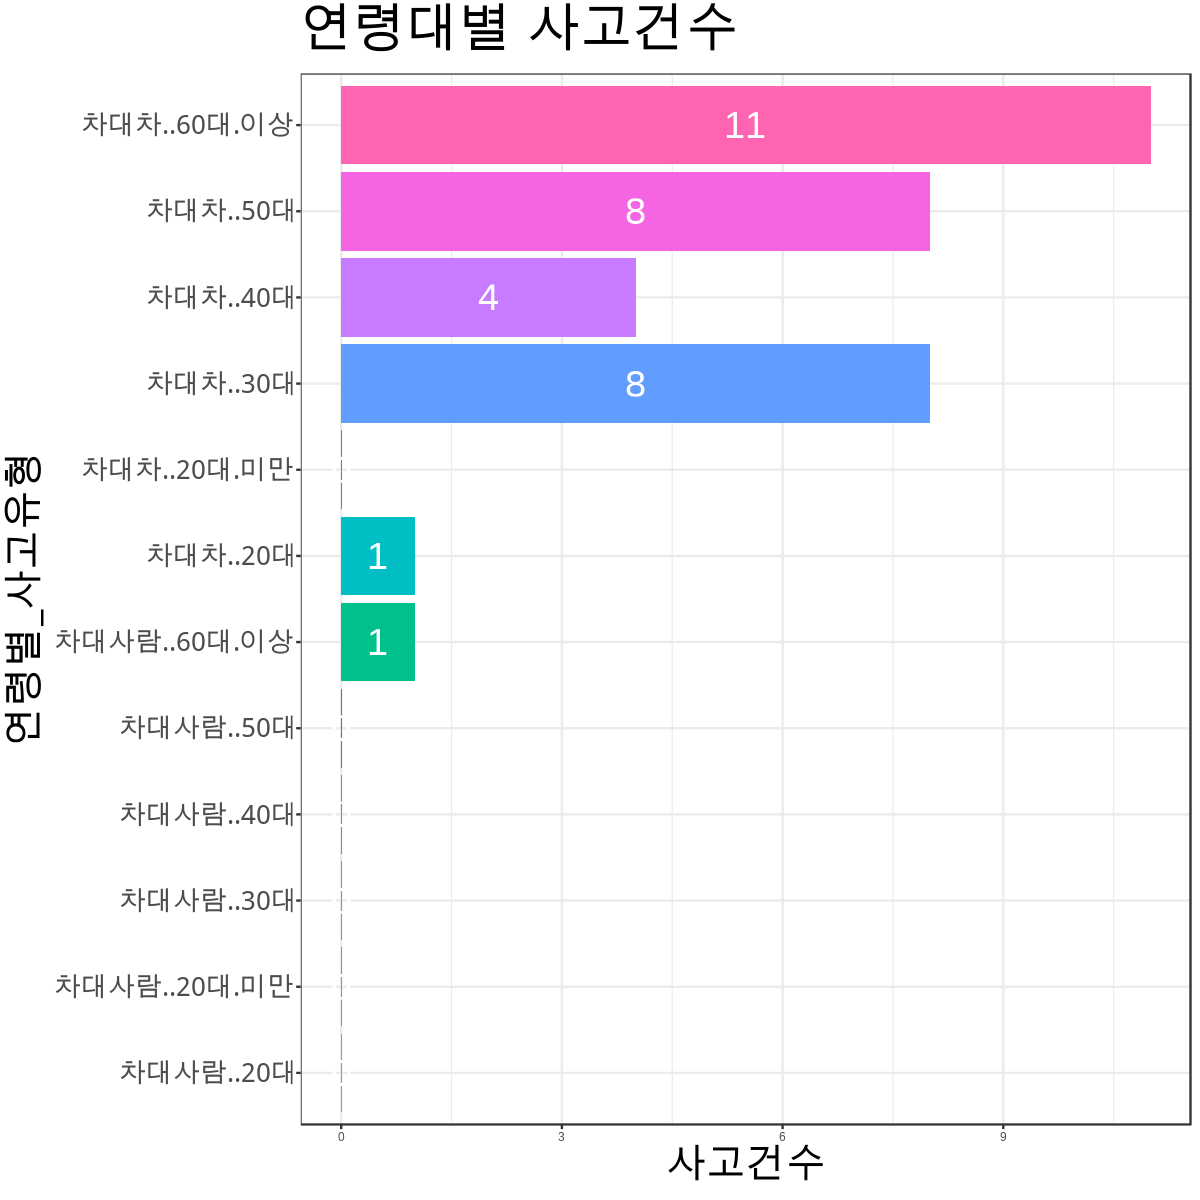

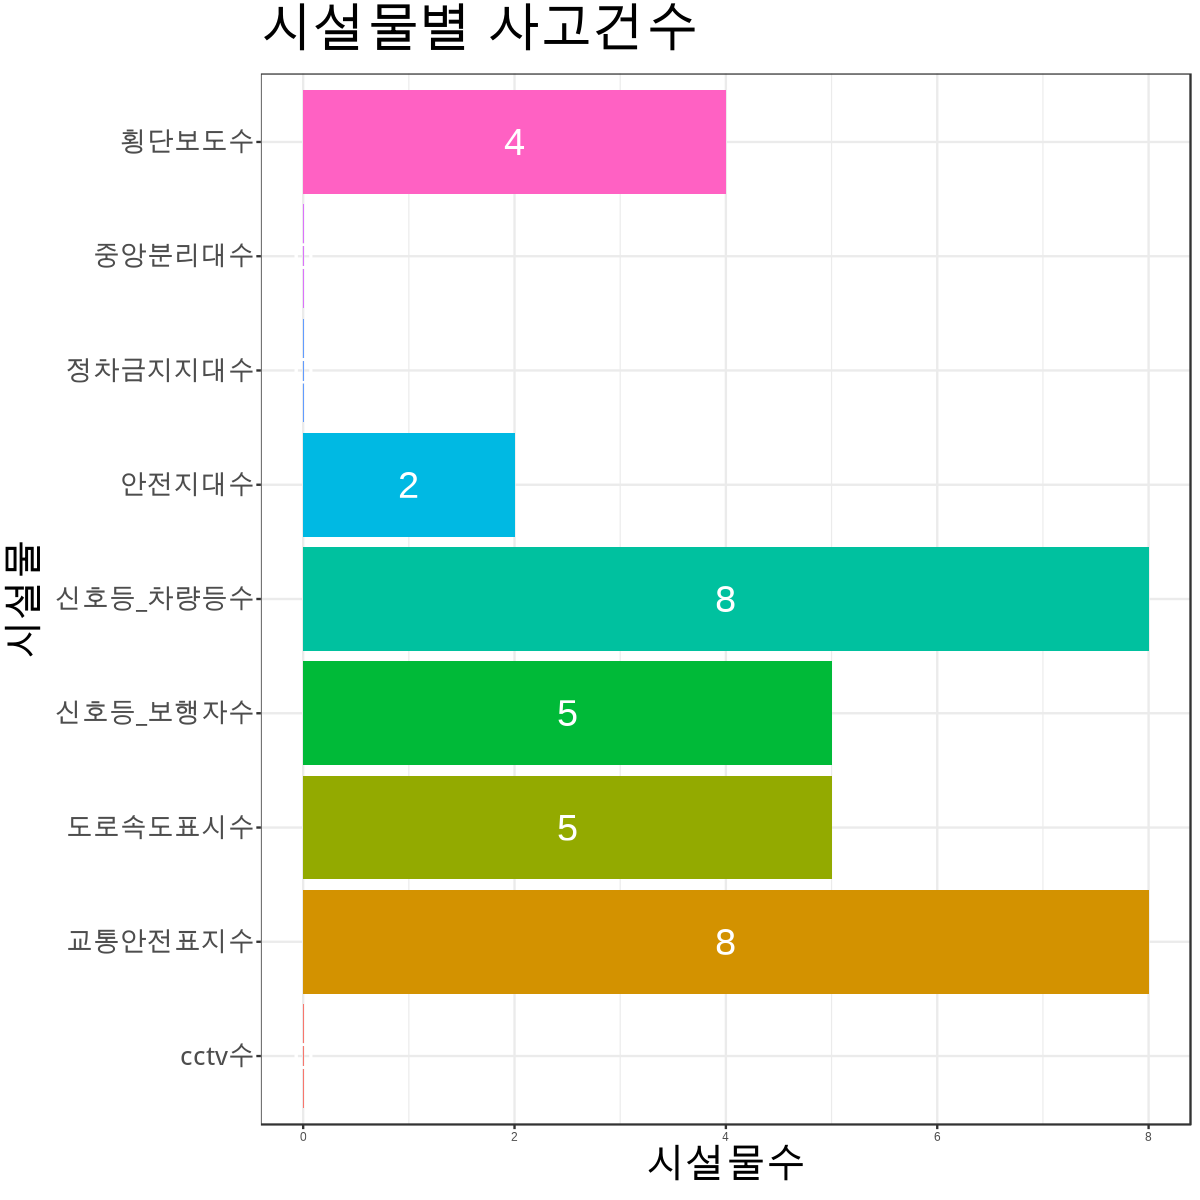

In [20]:
draw_bar("다바840114", "사고유형별 사고건수")
draw_bar2(rank_df3, "다바840114", "연령대별 사고건수")
draw_bar3("다바840114", "시설물별 사고건수")

#### (2) 다바890176 그래프

`summarise()` regrouping output by '사고유형3' (override with `.groups` argument)



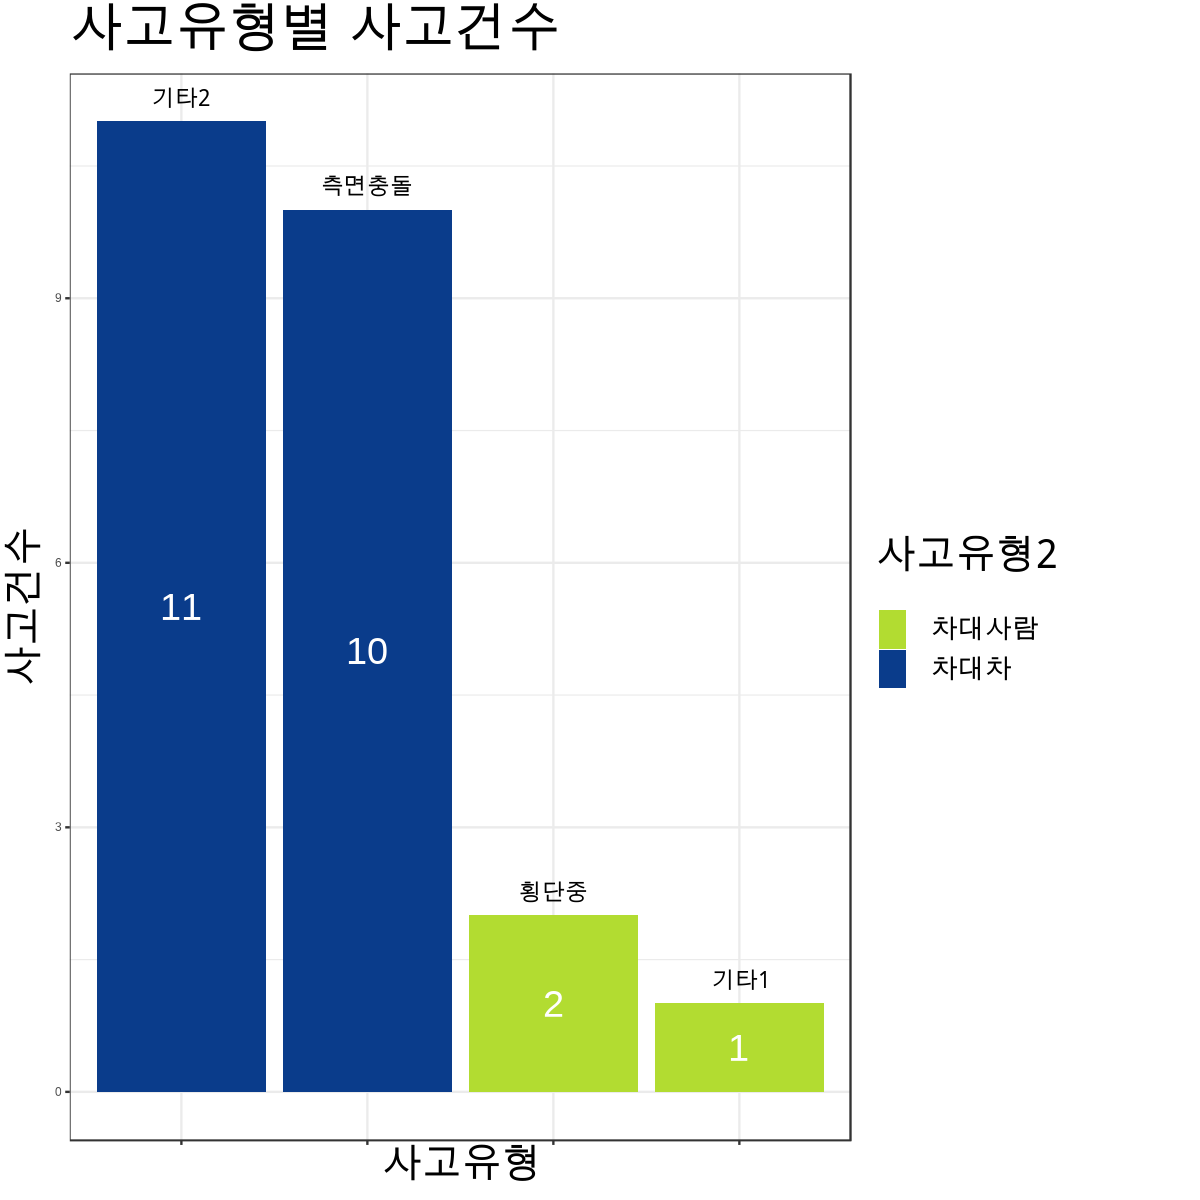

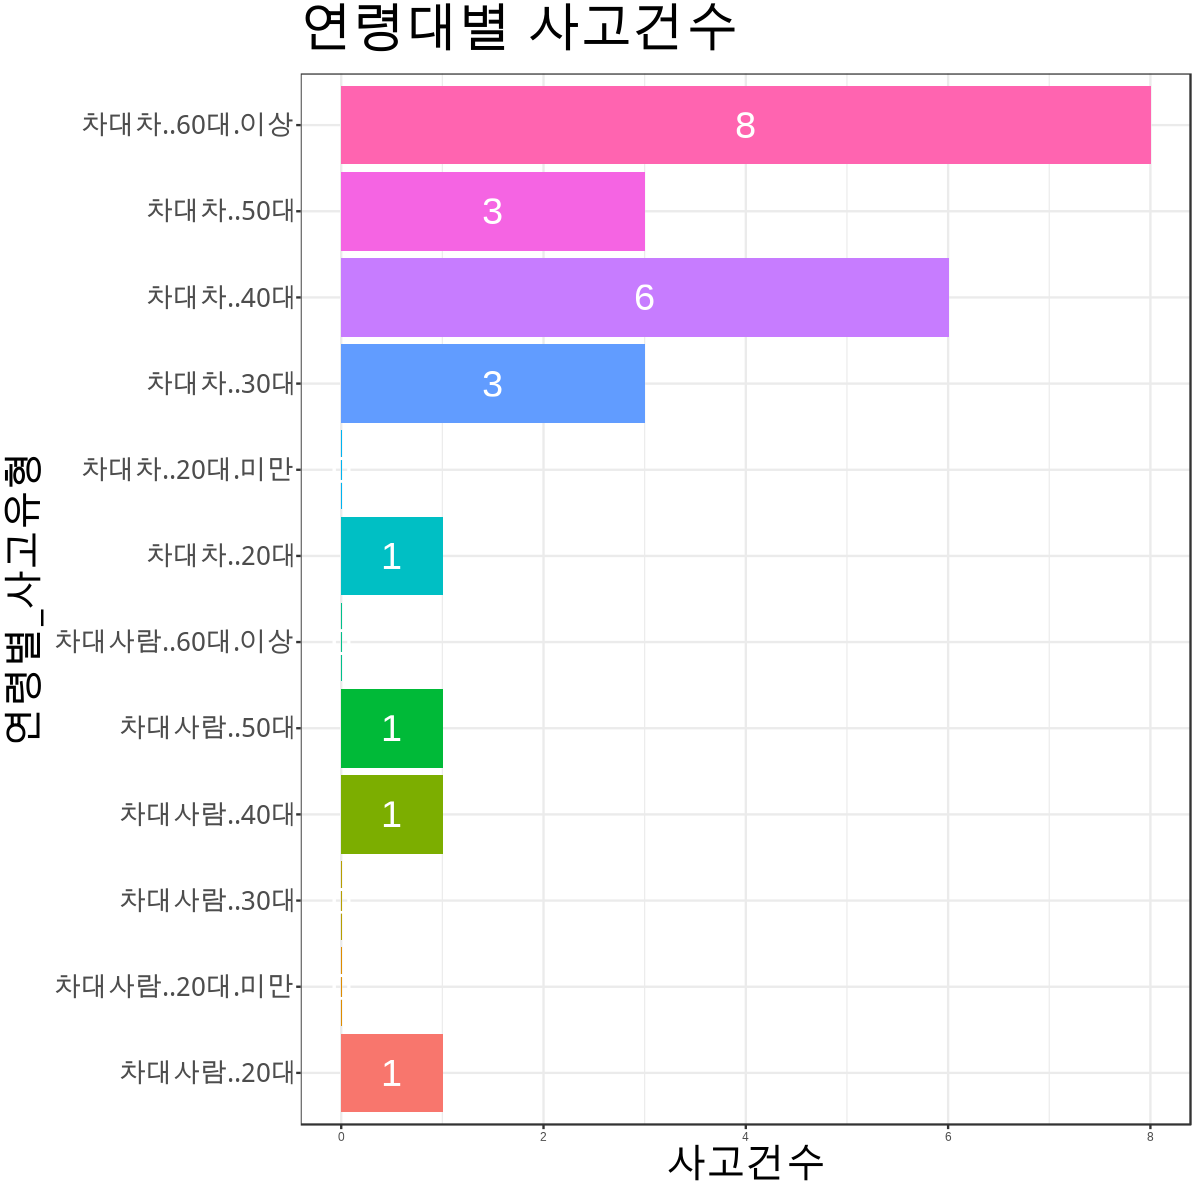

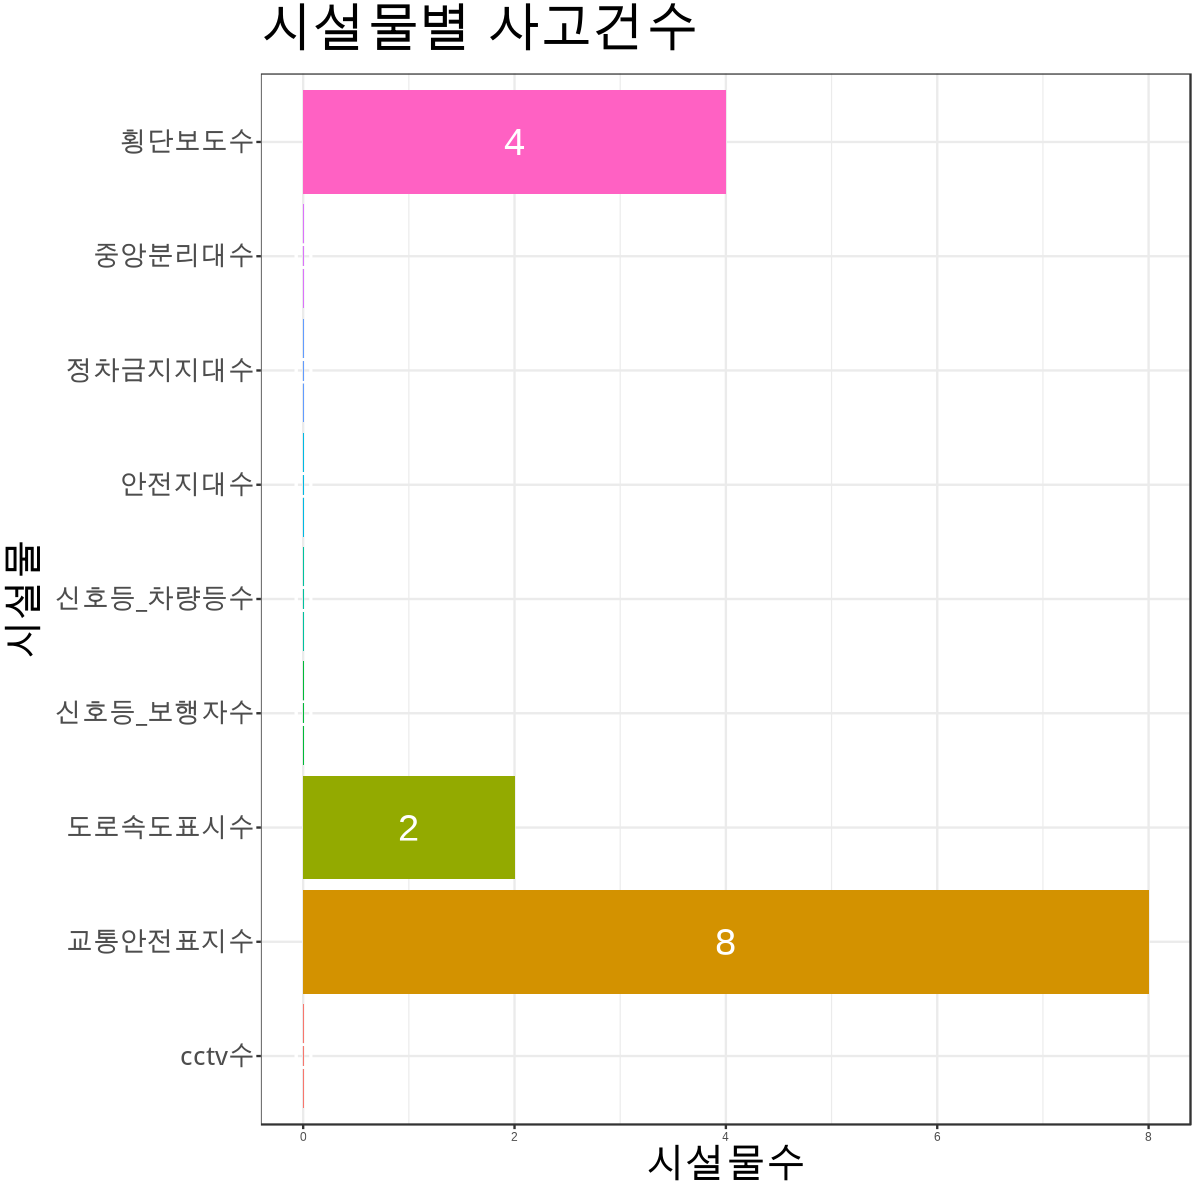

In [21]:
draw_bar("다바890176", "사고유형별 사고건수")
draw_bar2(rank_df3, "다바890176", "연령대별 사고건수")
draw_bar3("다바890176", "시설물별 사고건수")

#### (3) 다바905178 그래프

`summarise()` regrouping output by '사고유형3' (override with `.groups` argument)



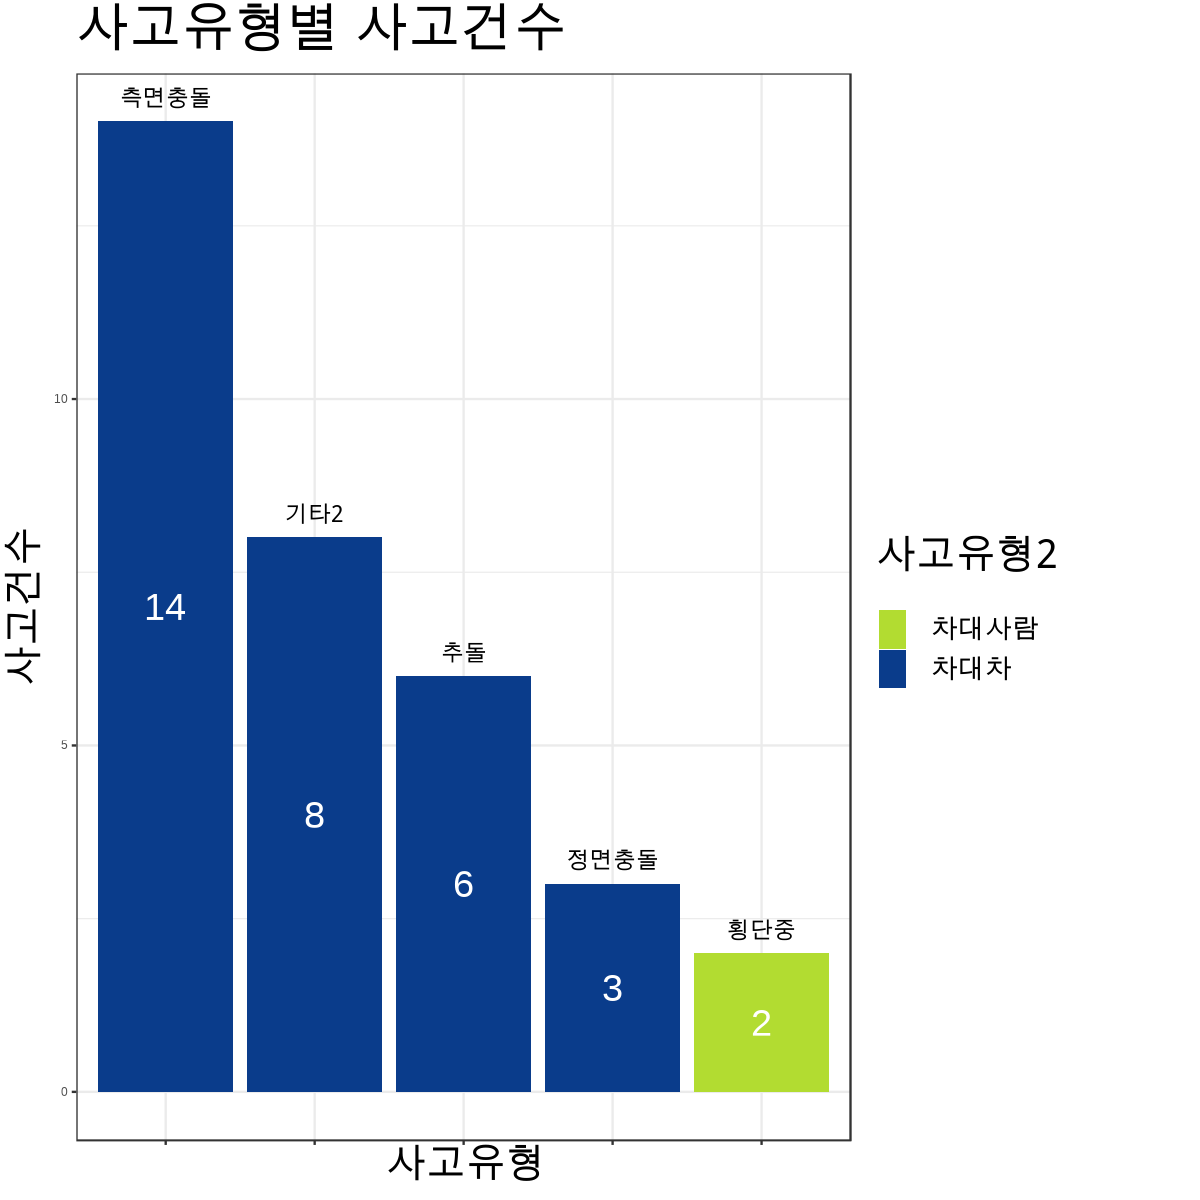

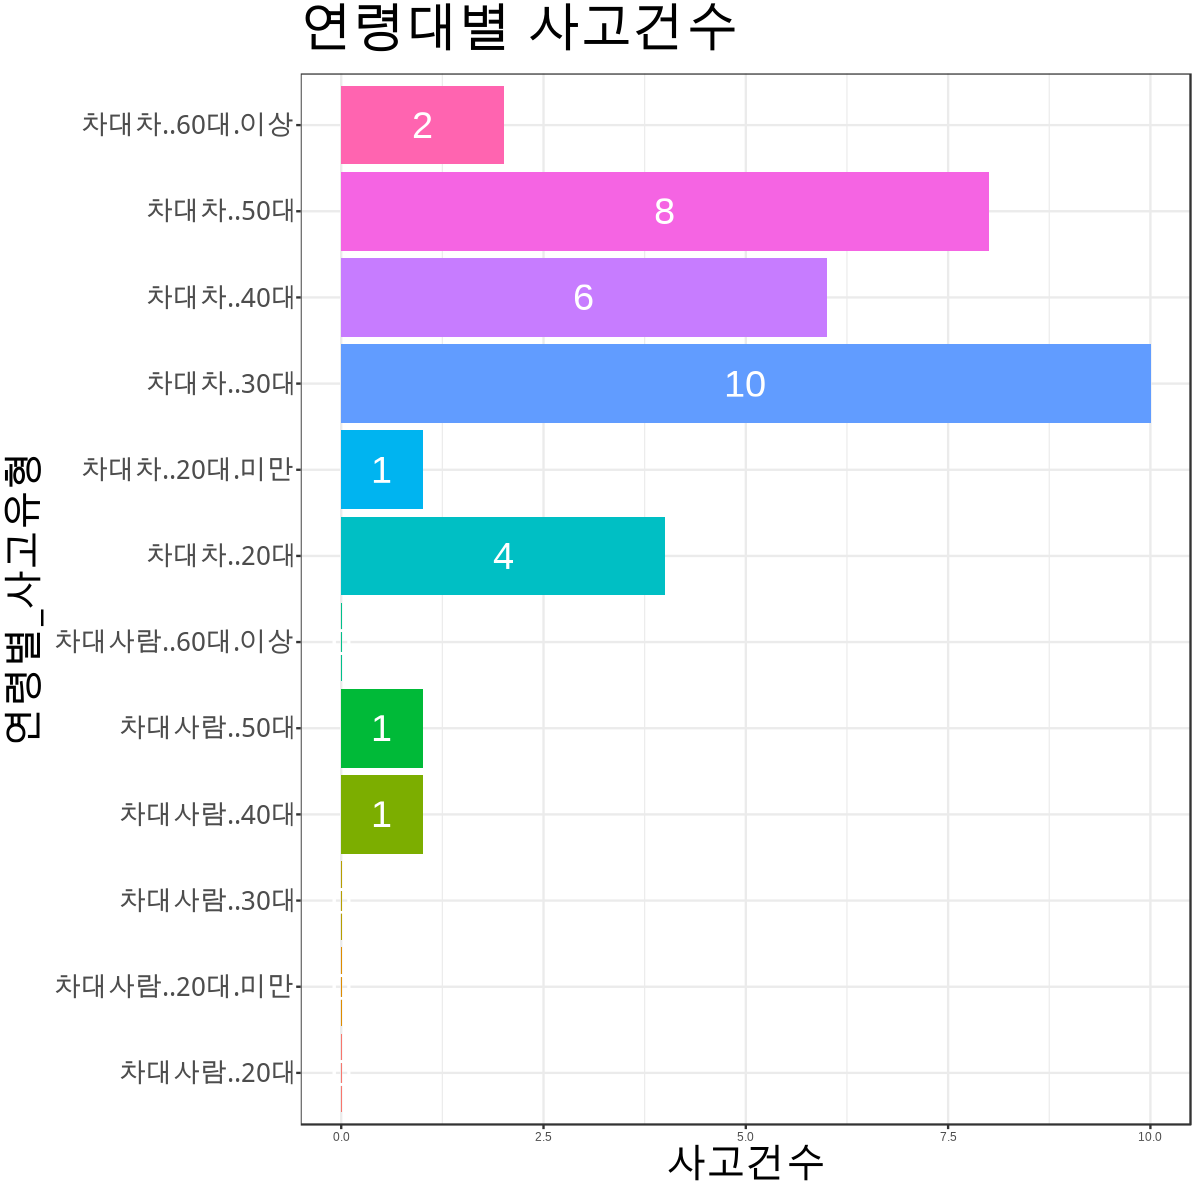

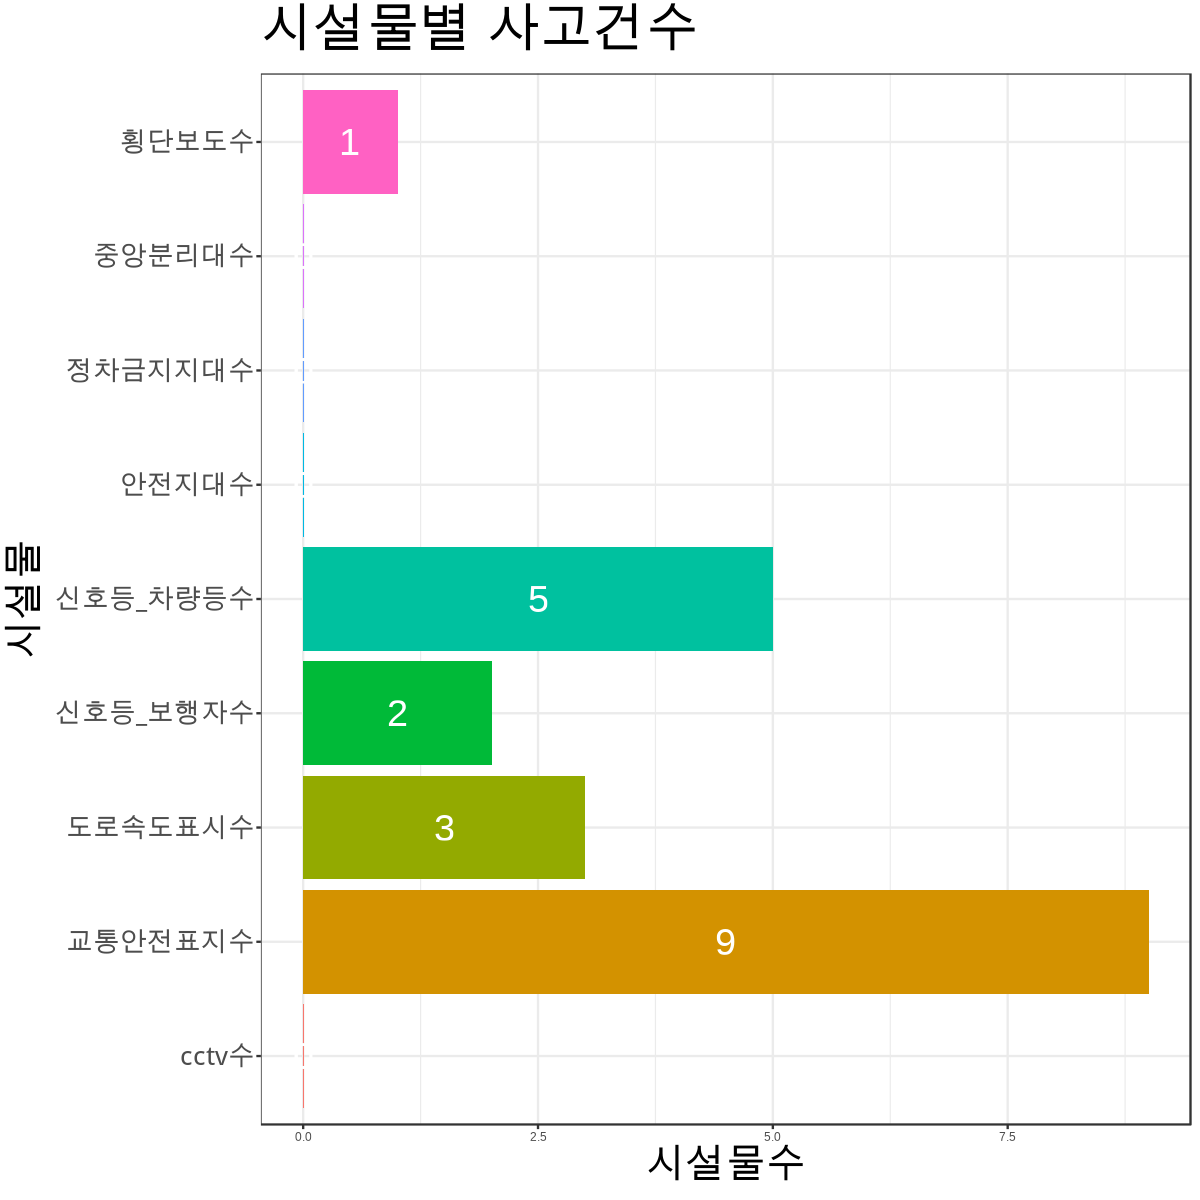

In [22]:
draw_bar("다바905178", "사고유형별 사고건수")
draw_bar2(rank_df3, "다바905178", "연령대별 사고건수")
draw_bar3("다바905178", "시설물별 사고건수")

#### (4) 다바960132 그래프

`summarise()` regrouping output by '사고유형3' (override with `.groups` argument)



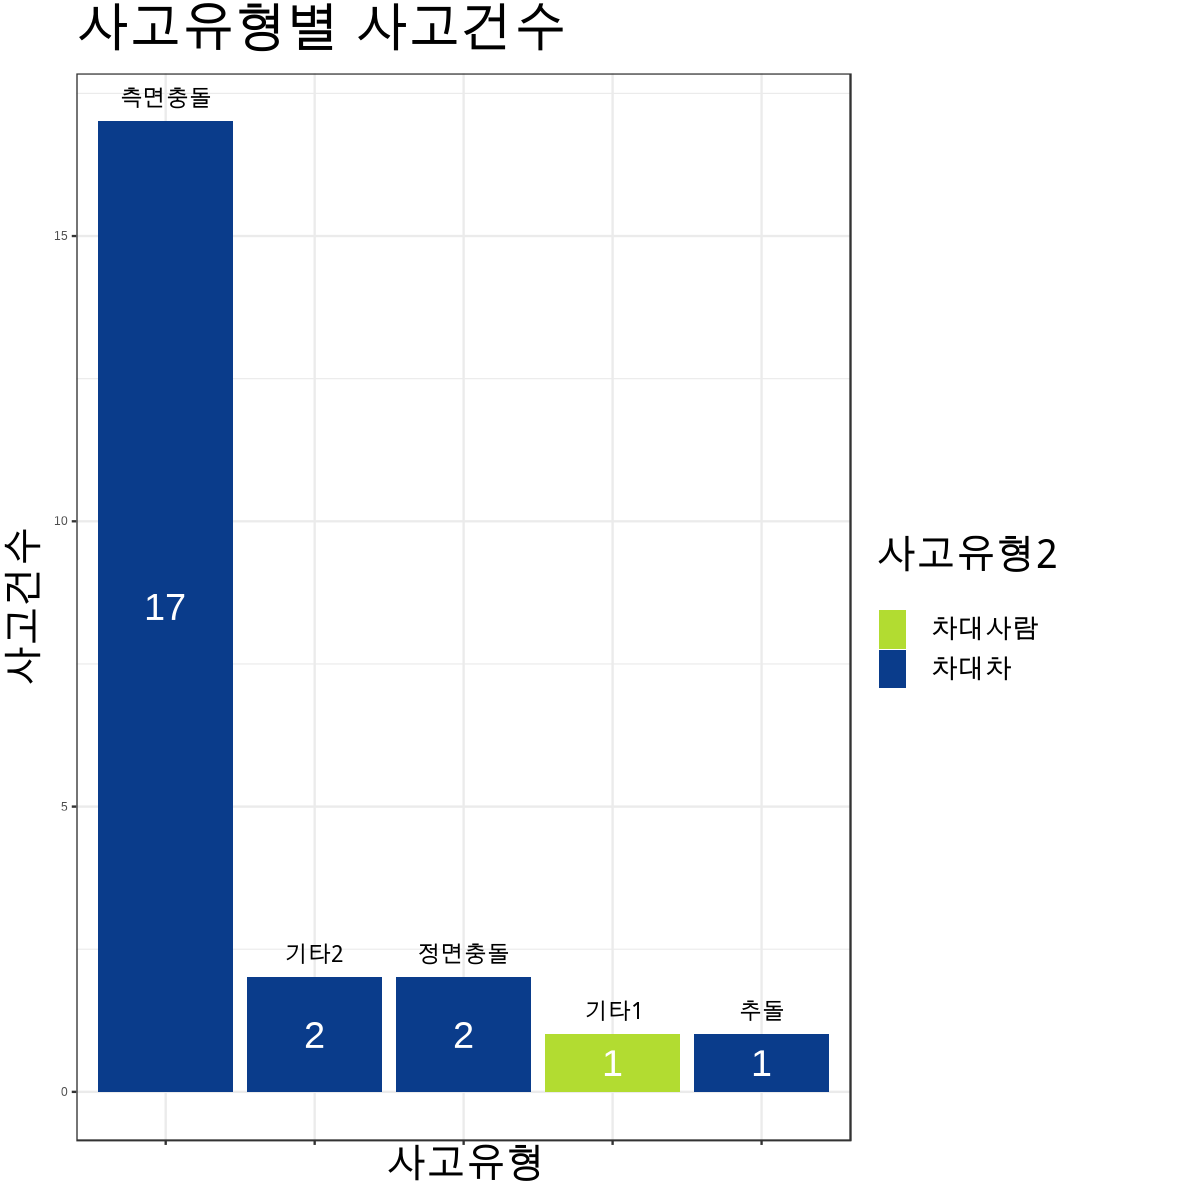

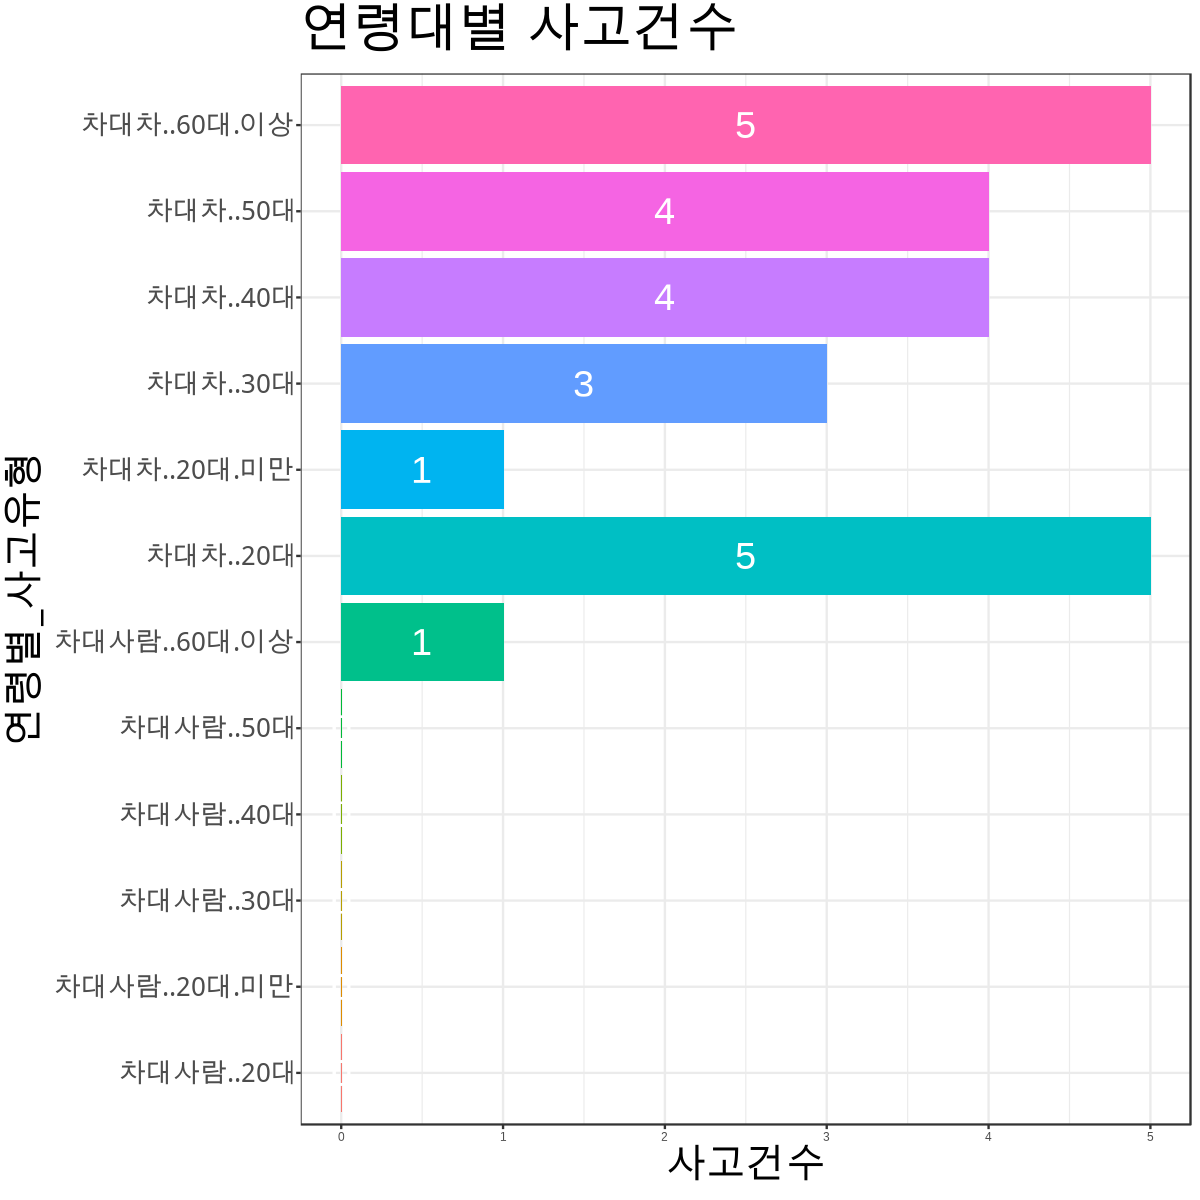

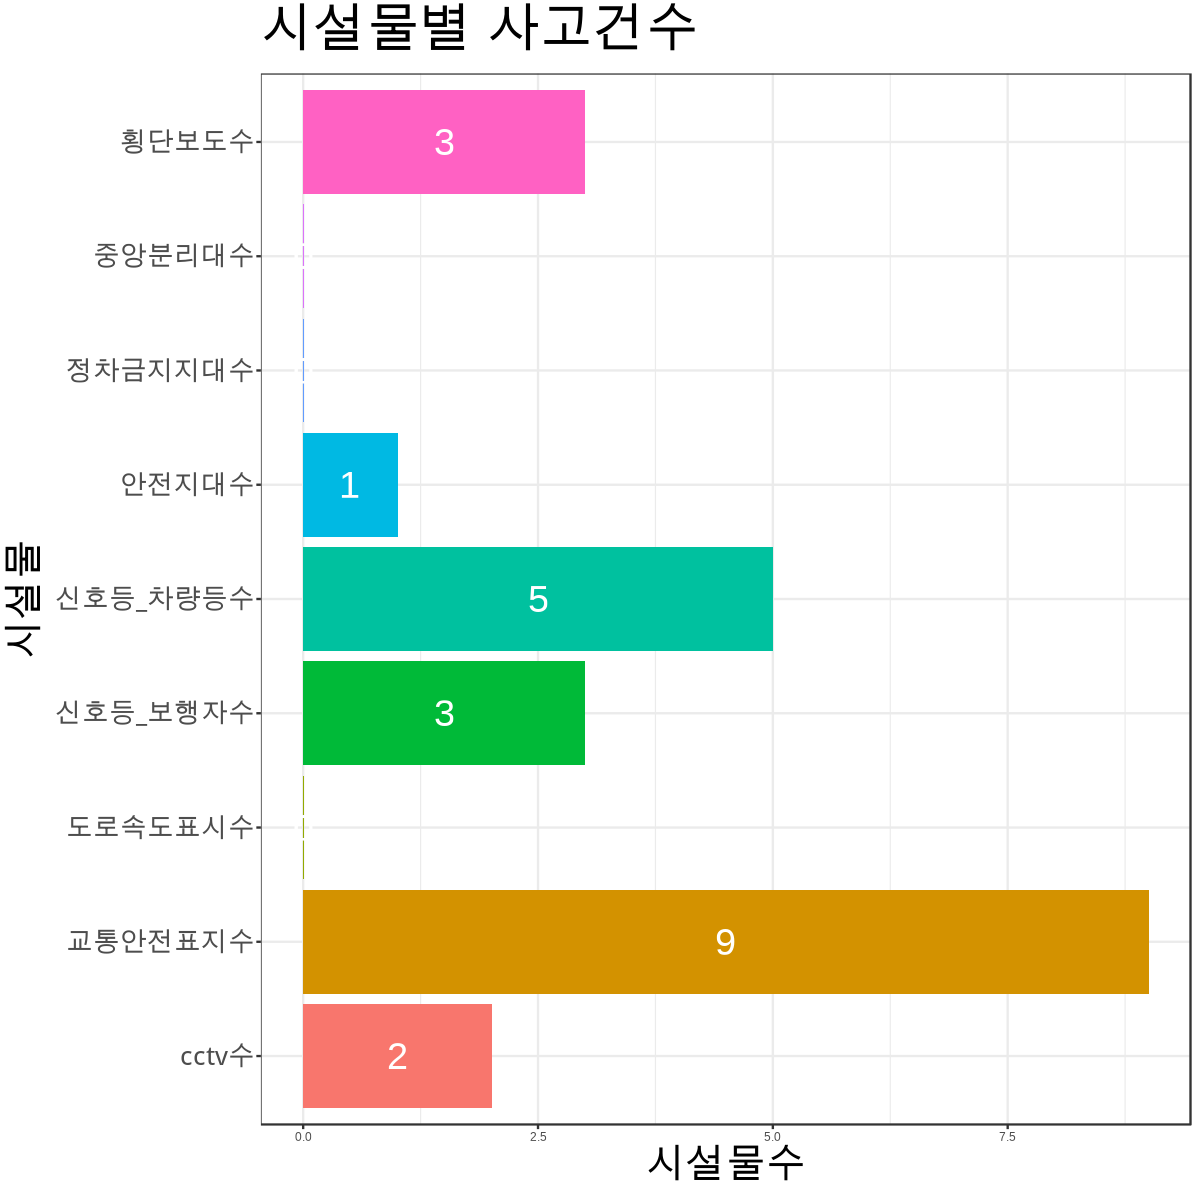

In [23]:
draw_bar("다바960132", "사고유형별 사고건수")
draw_bar2(rank_df3, "다바960132", "연령대별 사고건수")
draw_bar3("다바960132", "시설물별 사고건수")

#### (5) 다바831220 그래프

`summarise()` regrouping output by '사고유형3' (override with `.groups` argument)



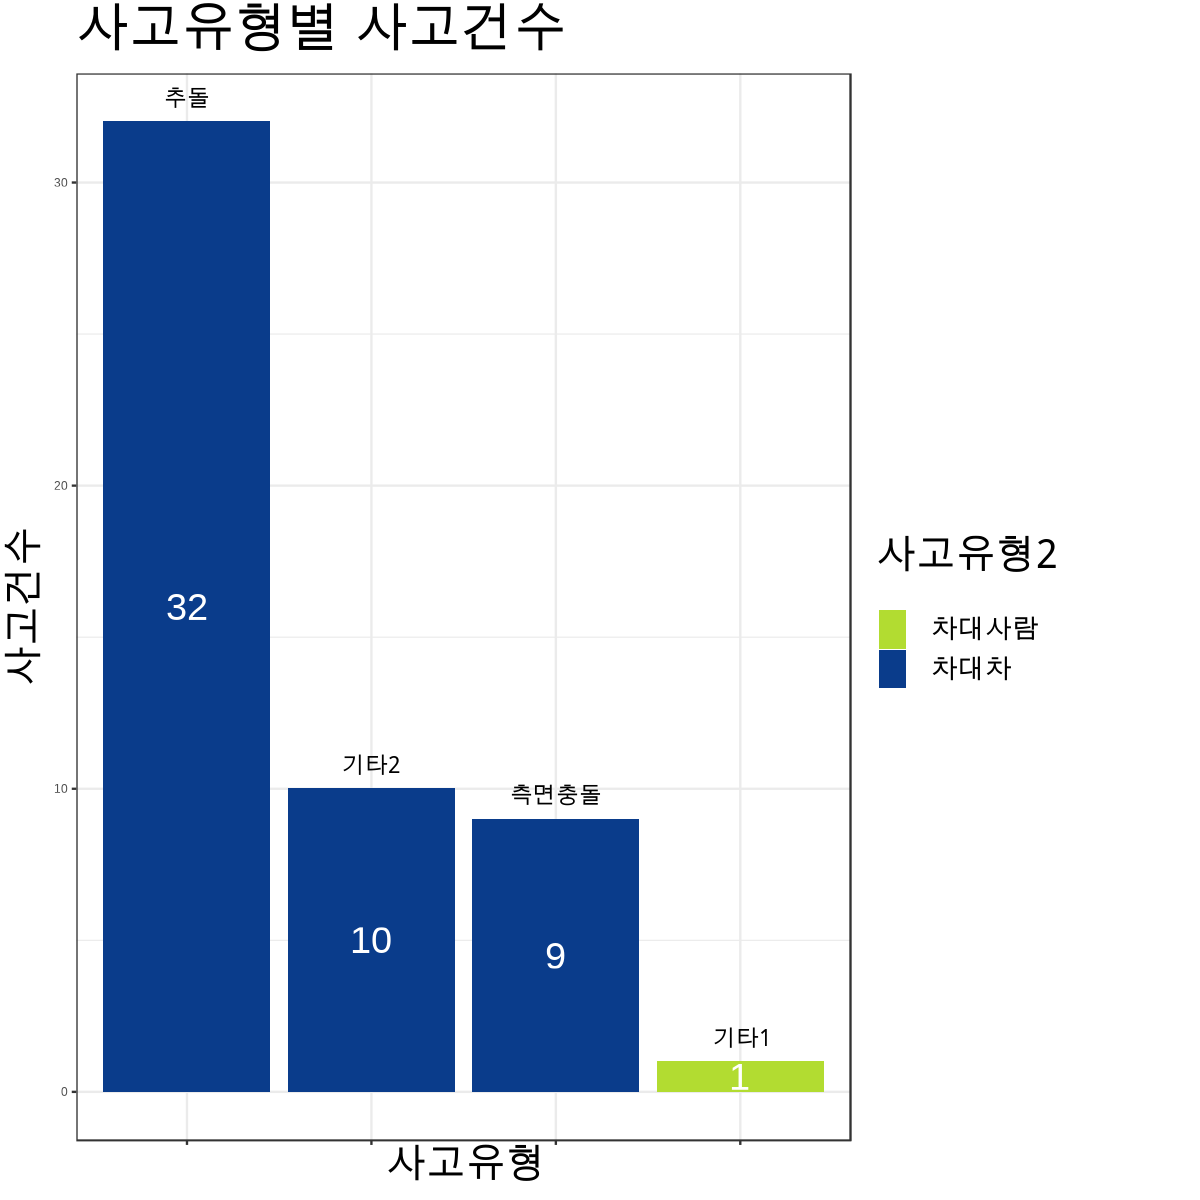

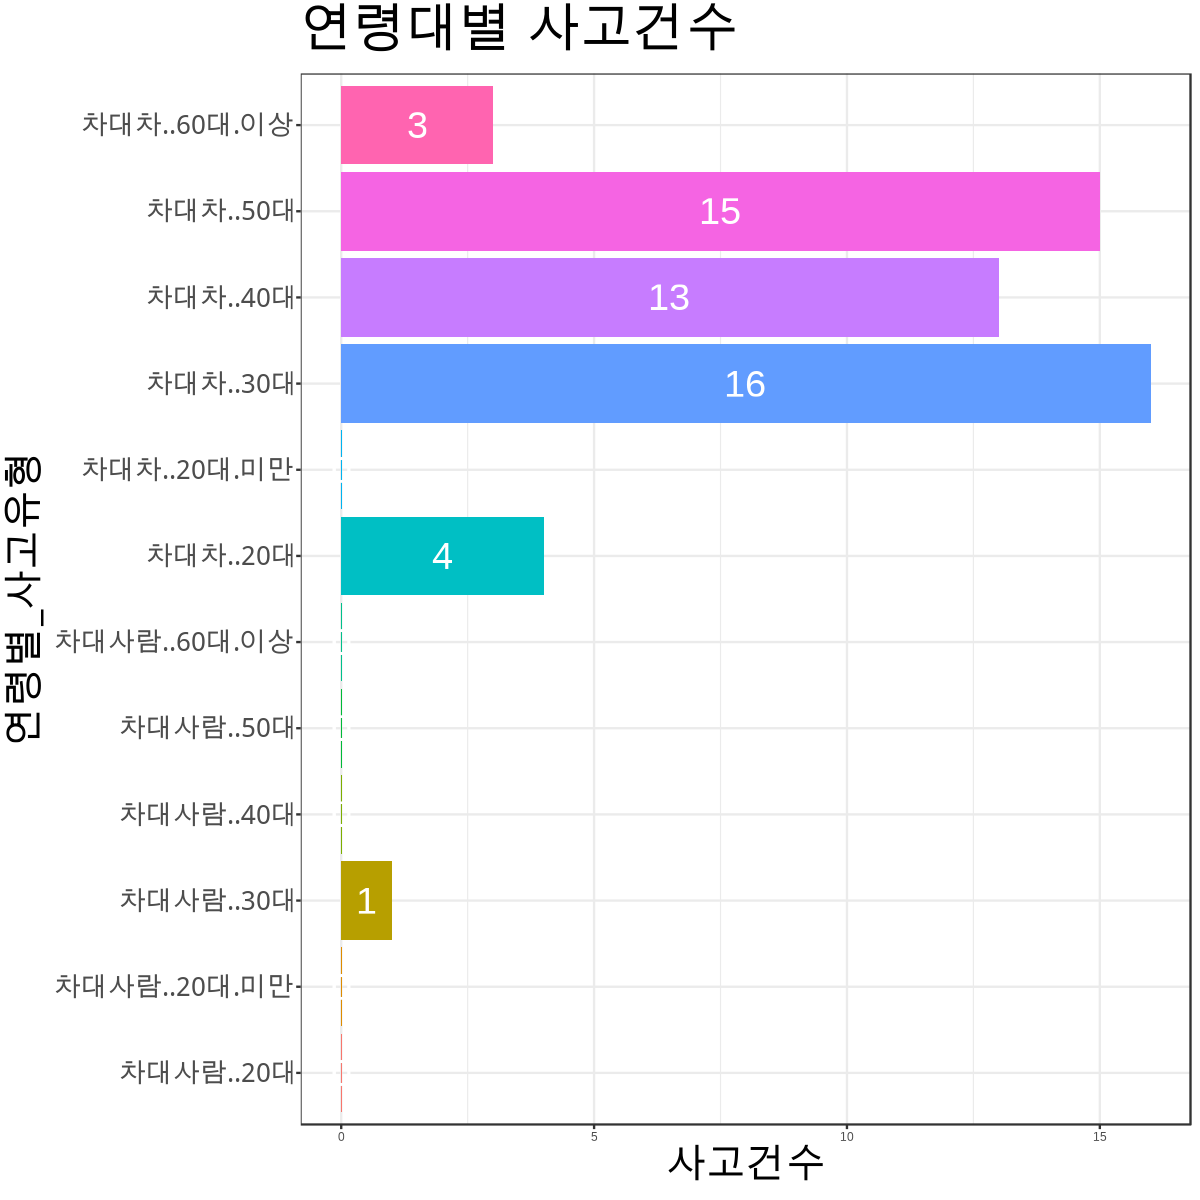

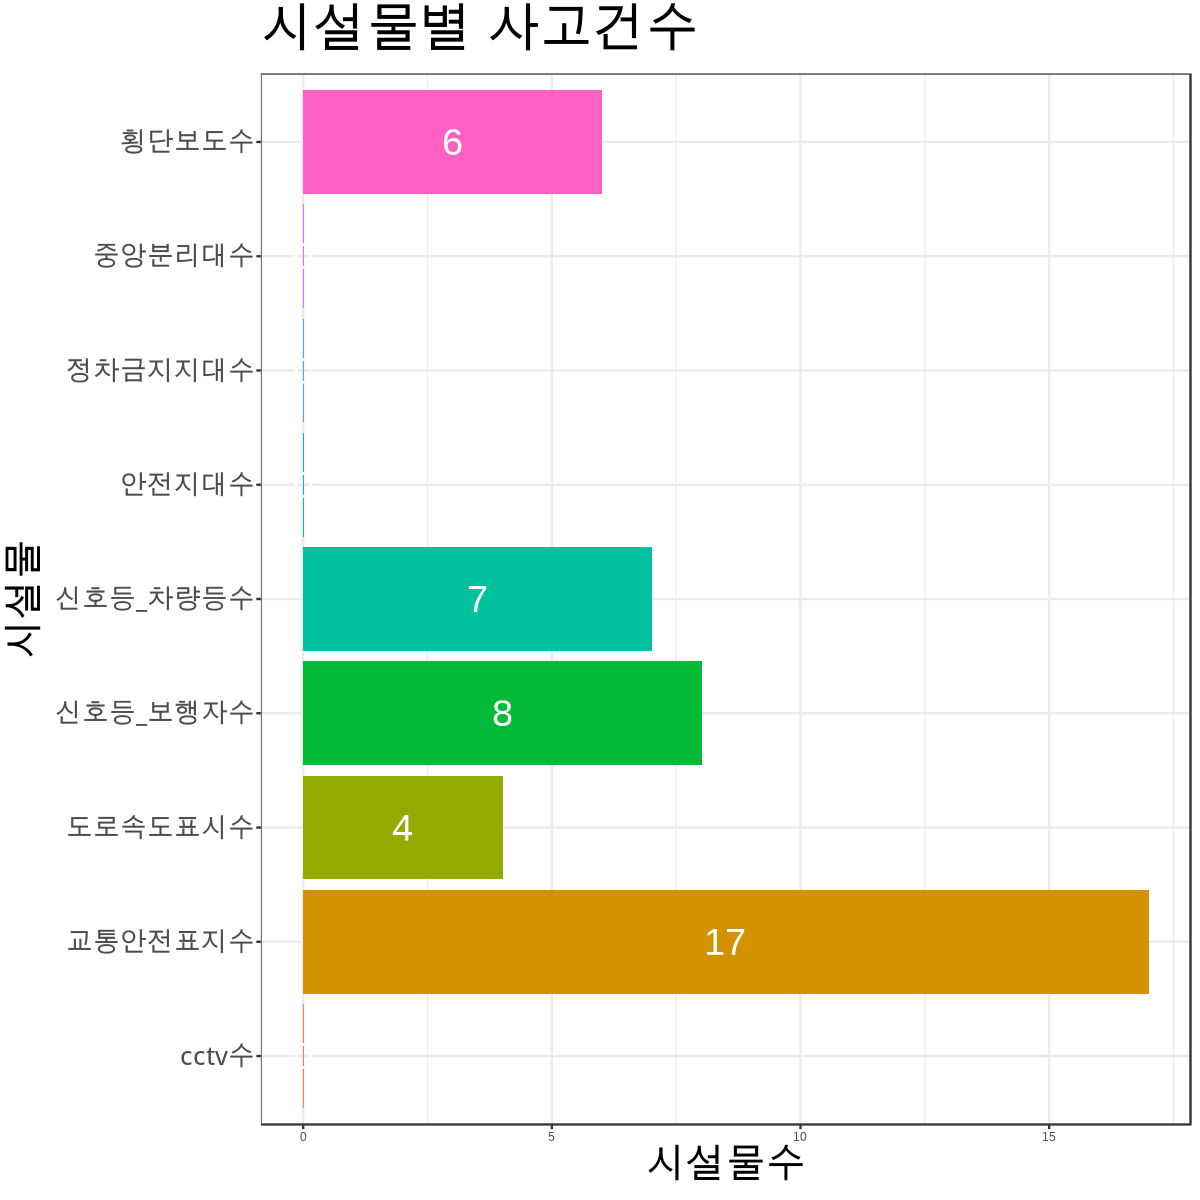

In [24]:
draw_bar("다바831220", "사고유형별 사고건수")
draw_bar2(rank_df3, "다바831220", "연령대별 사고건수")
draw_bar3("다바831220", "시설물별 사고건수")

In [25]:
rank_last <- grid[grid$gid %in% rank_last$gid,]
rank_last

,X,gid,acci_cnt,longitude,latitude
,<int>,<fct>,<int>,<dbl>,<dbl>
1607,1606,다바831220,52,127.3121,36.39579
2908,2907,다바840114,33,127.3224,36.30024
2917,2916,다바890176,24,127.3780,36.35621
5757,5756,다바960132,24,127.4560,36.31659
16612,16611,다바905178,34,127.3947,36.35803


In [26]:
# 심층분석 6개 지역에 대한 지도 시각화
m <- leaflet() %>% addTiles() %>%
setView(lng = 127.390594, lat = 36.348315, zoom = 12) %>% 
addProviderTiles("CartoDB.Positron") %>%
addPolygons(data = base, color = "gray") %>% 
addCircles(data = rank_last,lng=~longitude, lat=~latitude, color='navy',radius = 500)
m

HTML widgets cannot be represented in plain text (need html)